# Payment Date Prediction 


### Importing related Libraries 

In [1]:
import gc
import math
import PIL
import seaborn as sns
import xgboost as xgb
import numpy as np
import pandas as pd
import datetime
import random
import warnings
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,max_error,r2_score,median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_regression
from sklearn.preprocessing import MinMaxScaler,normalize,StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.decomposition import PCA
import featuretools as ft
from sklearn.svm import SVR
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector

### Store the dataset into the Dataframe


In [2]:
df=pd.read_csv('dataset.csv')

### Check the shape of the dataframe


In [3]:
df.shape

(50000, 19)

### Check the Detail information of the dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

### Display All the column names

In [5]:
list(df.columns)

['business_code',
 'cust_number',
 'name_customer',
 'clear_date',
 'buisness_year',
 'doc_id',
 'posting_date',
 'document_create_date',
 'document_create_date.1',
 'due_in_date',
 'invoice_currency',
 'document type',
 'posting_id',
 'area_business',
 'total_open_amount',
 'baseline_create_date',
 'cust_payment_terms',
 'invoice_id',
 'isOpen']

### Describe the entire dataset

In [6]:
df.describe()

,buisness_year,doc_id,document_create_date,document_create_date.1,due_in_date,posting_id,area_business,total_open_amount,baseline_create_date,invoice_id,isOpen
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.0,0.0,50000.000000,5.000000e+04,4.999400e+04,50000.000000
mean,2019.305700,2.012238e+09,2.019351e+07,2.019354e+07,2.019368e+07,1.0,NaN,32337.021651,2.019354e+07,2.011340e+09,0.200000
std,0.460708,2.885235e+08,4.496041e+03,4.482134e+03,4.470614e+03,0.0,NaN,39205.975231,4.482701e+03,2.766335e+08,0.400004
min,2019.000000,1.928502e+09,2.018123e+07,2.018123e+07,2.018122e+07,1.0,NaN,0.720000,2.018121e+07,1.928502e+09,0.000000
25%,2019.000000,1.929342e+09,2.019050e+07,2.019051e+07,2.019052e+07,1.0,NaN,4928.312500,2.019050e+07,1.929342e+09,0.000000
50%,2019.000000,1.929964e+09,2.019091e+07,2.019091e+07,2.019093e+07,1.0,NaN,17609.010000,2.019091e+07,1.929964e+09,0.000000
75%,2020.000000,1.930619e+09,2.020013e+07,2.020013e+07,2.020022e+07,1.0,NaN,47133.635000,2.020013e+07,1.930619e+09,0.000000
max,2020.000000,9.500000e+09,2.020052e+07,2.020052e+07,2.020071e+07,1.0,NaN,668593.360000,2.020052e+07,2.960636e+09,1.000000


# Data Cleaning

- Show top 5 records from the dataset

In [7]:
df.head(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200126,20200210.0,USD,RV,1.0,NaN,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200330,20200330,20200410.0,CAD,RV,1.0,NaN,3299.70,20200331.0,CA10,2.960623e+09,1
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0


### Display the Null values percentage against every columns (compare to the total number of records)

- Output expected : area_business - 100% null, clear_data = 20% null, invoice_id = 0.12% null

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df['isOpen'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
area_business,50000,1.00000
clear_date,10000,0.20000
invoice_id,6,0.00012
business_code,0,0.00000
invoice_currency,0,0.00000
cust_payment_terms,0,0.00000
baseline_create_date,0,0.00000
total_open_amount,0,0.00000
posting_id,0,0.00000
document type,0,0.00000


### Display Invoice_id and Doc_Id

- Note - Many of the would have same invoice_id and doc_id


In [9]:
df[['invoice_id','doc_id']].head(50)

,invoice_id,doc_id
0,1.930438e+09,1.930438e+09
1,1.929646e+09,1.929646e+09
2,1.929874e+09,1.929874e+09
3,2.960623e+09,2.960623e+09
4,1.930148e+09,1.930148e+09
5,2.960581e+09,2.960581e+09
6,1.930083e+09,1.930083e+09
7,1.930659e+09,1.930659e+09
8,1.929440e+09,1.929440e+09
9,1.928819e+09,1.928819e+09


#### Write a code to check - 'baseline_create_date',"document_create_date",'document_create_date.1' - these columns are almost same.

- Please note, if they are same, we need to drop them later



In [10]:
df[df['baseline_create_date']==df['document_create_date']]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0
11,U001,0200743129,BROOKS co,2019-01-22 00:00:00,2019.0,1.928551e+09,2019-01-02,20190102,20190102,20190117.0,USD,RV,1.0,NaN,103147.37,20190102.0,NAA8,1.928551e+09,0
12,U001,0200186937,SYSC corporation,2019-05-06 00:00:00,2019.0,1.929152e+09,2019-04-15,20190415,20190415,20190430.0,USD,RV,1.0,NaN,16381.45,20190415.0,NAA8,1.929152e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49982,U001,0200148860,DOLLA co,NaN,2020.0,1.930638e+09,2020-03-11,20200311,20200311,20200326.0,USD,RV,1.0,NaN,4967.06,20200311.0,NAA8,1.930638e+09,1
49983,U001,0200793513,KROGER associates,2019-07-17 00:00:00,2019.0,1.929565e+09,2019-07-02,20190702,20190702,20190717.0,USD,RV,1.0,NaN,66128.25,20190702.0,NAA8,1.929565e+09,0
49990,U001,0200765011,MAINES llc,2019-06-06 00:00:00,2019.0,1.929365e+09,2019-05-22,20190522,20190522,20190606.0,USD,RV,1.0,NaN,4008.05,20190522.0,NAA8,1.929365e+09,0
49992,U001,0200900909,SYSCO co,NaN,2020.0,1.930702e+09,2020-03-25,20200325,20200325,20200409.0,USD,RV,1.0,NaN,1998.64,20200325.0,NAA8,1.930702e+09,1


In [11]:
df[df['document_create_date.1']==df['document_create_date']]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200330,20200330,20200410.0,CAD,RV,1.0,NaN,3299.70,20200331.0,CA10,2.960623e+09,1
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0
5,CA02,0140106181,THE corporation,2019-12-04 00:00:00,2019.0,2.960581e+09,2019-09-20,20190920,20190920,20191004.0,CAD,RV,1.0,NaN,22225.84,20190924.0,CA10,2.960581e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49983,U001,0200793513,KROGER associates,2019-07-17 00:00:00,2019.0,1.929565e+09,2019-07-02,20190702,20190702,20190717.0,USD,RV,1.0,NaN,66128.25,20190702.0,NAA8,1.929565e+09,0
49990,U001,0200765011,MAINES llc,2019-06-06 00:00:00,2019.0,1.929365e+09,2019-05-22,20190522,20190522,20190606.0,USD,RV,1.0,NaN,4008.05,20190522.0,NAA8,1.929365e+09,0
49992,U001,0200900909,SYSCO co,NaN,2020.0,1.930702e+09,2020-03-25,20200325,20200325,20200409.0,USD,RV,1.0,NaN,1998.64,20200325.0,NAA8,1.930702e+09,1
49993,U001,0200726979,BJ'S,2020-03-25 00:00:00,2020.0,1.930378e+09,2020-01-08,20200108,20200108,20200123.0,USD,RV,1.0,NaN,31.62,20200108.0,NAA8,1.930378e+09,0


In [12]:
df[df['document_create_date.1']==df['baseline_create_date']]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200126,20200210.0,USD,RV,1.0,NaN,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0
6,U001,0200769623,WAL-MAR in,2019-11-12 00:00:00,2019.0,1.930083e+09,2019-11-01,20191031,20191101,20191116.0,USD,RV,1.0,NaN,7358.49,20191101.0,NAH4,1.930083e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,U001,0200762301,C&S WH trust,2019-07-25 00:00:00,2019.0,1.929601e+09,2019-07-10,20190709,20190710,20190725.0,USD,RV,1.0,NaN,84780.40,20190710.0,NAC6,1.929601e+09,0
49995,U001,0200561861,CO corporation,NaN,2020.0,1.930797e+09,2020-04-21,20200417,20200421,20200506.0,USD,RV,1.0,NaN,3187.86,20200421.0,NAA8,1.930797e+09,1
49996,U001,0200769623,WAL-MAR co,2019-09-03 00:00:00,2019.0,1.929744e+09,2019-08-15,20190814,20190815,20190830.0,USD,RV,1.0,NaN,6766.54,20190815.0,NAH4,1.929744e+09,0
49997,U001,0200772595,SAFEW associates,2020-03-05 00:00:00,2020.0,1.930537e+09,2020-02-19,20200218,20200219,20200305.0,USD,RV,1.0,NaN,6120.86,20200219.0,NAA8,1.930537e+09,0


#### Please check, Column 'posting_id' is constant columns or not


In [13]:
list(df['posting_id'].unique())

[1.0]

#### Please check 'isOpen' is a constant column and relevant column for this project or not

In [14]:
list(df['isOpen'].unique())

[0, 1]

### Write the code to drop all the following columns from the dataframe

- 'area_business'
- "posting_id"
- "invoice_id"
- "document_create_date"
- "isOpen"
- 'document type' 
- 'document_create_date.1

In [15]:

df=df.drop(columns=['area_business',"posting_id","invoice_id","document_create_date","isOpen",'document type','document_create_date.1'])

### Please check from the dataframe whether all the columns are removed or not 

In [16]:
list(df.columns)


['business_code',
 'cust_number',
 'name_customer',
 'clear_date',
 'buisness_year',
 'doc_id',
 'posting_date',
 'due_in_date',
 'invoice_currency',
 'total_open_amount',
 'baseline_create_date',
 'cust_payment_terms']

### Show all the Duplicate rows from the dataframe

In [17]:
duplicate=df.duplicated()
df[duplicate]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
1041,U001,0200769623,WAL-MAR in,2019-03-12 00:00:00,2019.0,1.928870e+09,2019-02-28,20190315.0,USD,19557.41,20190228.0,NAH4
2400,U001,0200769623,WAL-MAR trust,2019-08-28 00:00:00,2019.0,1.929758e+09,2019-08-18,20190902.0,USD,5600.41,20190818.0,NAH4
2584,U001,0200769623,WAL-MAR corporation,2019-12-16 00:00:00,2019.0,1.930217e+09,2019-12-04,20191219.0,USD,35352.17,20191204.0,NAH4
3755,U001,0200769623,WAL-MAR,2019-11-22 00:00:00,2019.0,1.930137e+09,2019-11-12,20191127.0,USD,2982.64,20191112.0,NAH4
3873,CA02,0140104409,LOB associates,NaN,2020.0,2.960629e+09,2020-04-14,20200425.0,CAD,82975.82,20200415.0,CA10
...,...,...,...,...,...,...,...,...,...,...,...,...
49928,U001,0200915438,GROC trust,2019-08-15 00:00:00,2019.0,1.929646e+09,2019-07-25,20190809.0,USD,6969.00,20190725.0,NAA8
49963,U001,0200759878,SA us,2019-01-29 00:00:00,2019.0,1.928614e+09,2019-01-13,20190128.0,USD,10968.24,20190113.0,NAH4
49986,U001,0200772670,ASSOCIAT foundation,2019-06-12 00:00:00,2019.0,1.929403e+09,2019-05-29,20190613.0,USD,155837.53,20190529.0,NAU5
49990,U001,0200765011,MAINES llc,2019-06-06 00:00:00,2019.0,1.929365e+09,2019-05-22,20190606.0,USD,4008.05,20190522.0,NAA8


### Display the Number of Duplicate Rows

In [18]:
print(duplicate.sum())

1161


### Drop all the Duplicate Rows

In [19]:
df.drop_duplicates(inplace=True)

#### Now check for all duplicate rows now

- Note - It must be 0 by now

In [20]:
dp1=df.duplicated()
dp1.sum()

0

### Check for the number of Rows and Columns in your dataset

In [21]:
df.shape

(48839, 12)

### Find out the total count of null values in each columns

In [22]:
df.isnull().sum()

business_code              0
cust_number                0
name_customer              0
clear_date              9681
buisness_year              0
doc_id                     0
posting_date               0
due_in_date                0
invoice_currency           0
total_open_amount          0
baseline_create_date       0
cust_payment_terms         0
dtype: int64

#Data type Conversion 

### Please check the data type of each column of the dataframe

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48839 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   business_code         48839 non-null  object 
 1   cust_number           48839 non-null  object 
 2   name_customer         48839 non-null  object 
 3   clear_date            39158 non-null  object 
 4   buisness_year         48839 non-null  float64
 5   doc_id                48839 non-null  float64
 6   posting_date          48839 non-null  object 
 7   due_in_date           48839 non-null  float64
 8   invoice_currency      48839 non-null  object 
 9   total_open_amount     48839 non-null  float64
 10  baseline_create_date  48839 non-null  float64
 11  cust_payment_terms    48839 non-null  object 
dtypes: float64(5), object(7)
memory usage: 4.8+ MB


### Check the datatype format of below columns

- clear_date  
- posting_date
- due_in_date 
- baseline_create_date

In [24]:
df[['clear_date','posting_date','due_in_date','baseline_create_date']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48839 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clear_date            39158 non-null  object 
 1   posting_date          48839 non-null  object 
 2   due_in_date           48839 non-null  float64
 3   baseline_create_date  48839 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.9+ MB


### converting date columns into date time formats

- clear_date  
- posting_date
- due_in_date 
- baseline_create_date


- **Note - You have to convert all these above columns into "%Y%m%d" format**

In [25]:
df['clear_date'] = pd.to_datetime(df['clear_date'])
df['posting_date'] = pd.to_datetime(df['posting_date'])
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d',errors='coerce')
df['baseline_create_date'] = pd.to_datetime(df['baseline_create_date'], format='%Y%m%d',errors='coerce')

### Please check the datatype of all the columns after conversion of the above 4 columns

In [26]:
df[['clear_date','posting_date','due_in_date','baseline_create_date']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48839 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   clear_date            39158 non-null  datetime64[ns]
 1   posting_date          48839 non-null  datetime64[ns]
 2   due_in_date           48839 non-null  datetime64[ns]
 3   baseline_create_date  48839 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 1.9 MB


#### the invoice_currency column contains two different categories, USD and CAD

- Please do a count of each currency 

In [27]:
df['invoice_currency'].value_counts()

USD    45011
CAD     3828
Name: invoice_currency, dtype: int64

#### display the "total_open_amount" column value

In [28]:
df['total_open_amount']

0        54273.28
1        79656.60
2         2253.86
3         3299.70
4        33133.29
           ...   
49995     3187.86
49996     6766.54
49997     6120.86
49998       63.48
49999     1790.30
Name: total_open_amount, Length: 48839, dtype: float64

### Convert all CAD into USD currency of "total_open_amount" column

- 1 CAD = 0.7 USD
- Create a new column i.e "converted_usd" and store USD and convered CAD to USD

In [29]:
df_CAD=df[df['invoice_currency']=='CAD']
df_CAD.shape

(3828, 12)

In [30]:
df_USD=df[df['invoice_currency']=='USD']
df_USD.shape

(45011, 12)

In [31]:
def updateTotal(total_open_amount):
    return total_open_amount*0.79
def updateCurrency(invoice_currency):
    return 'USD'
df_CAD['total_open_amount']=df_CAD['total_open_amount'].apply(updateTotal)
df_CAD['invoice_currency']=df_CAD['invoice_currency'].apply(updateCurrency)

In [32]:
df=pd.concat([df_USD,df_CAD],ignore_index=True)

In [33]:
df['converted_usd']=df['total_open_amount']

### Display the new "converted_usd" column values

In [34]:
df[['converted_usd']].head(10)

,converted_usd
0,54273.28
1,79656.60
2,2253.86
3,33133.29
4,7358.49
5,11173.02
6,15995.04
7,28.63
8,3525.59
9,103147.37


### Display year wise total number of record 

- Note -  use "buisness_year" column for this 

In [35]:
df['buisness_year'].value_counts()

2019.0    33975
2020.0    14864
Name: buisness_year, dtype: int64

### Write the code to delete the following columns 

- 'invoice_currency'
- 'total_open_amount', 

In [36]:
df.drop(columns=['invoice_currency','total_open_amount'],inplace=True)

### Write a code to check the number of columns in dataframe

In [37]:
list(df.columns)

['business_code',
 'cust_number',
 'name_customer',
 'clear_date',
 'buisness_year',
 'doc_id',
 'posting_date',
 'due_in_date',
 'baseline_create_date',
 'cust_payment_terms',
 'converted_usd']

# Splitting the Dataset 

### Look for all columns containing null value

- Note - Output expected is only one column 

In [38]:
 df.columns[df.isna().any()].tolist()

['clear_date']

#### Find out the number of null values from the column that you got from the above code

In [39]:
df['clear_date'].isnull().sum()


9681

### On basis of the above column we are spliting data into dataset

- First dataframe (refer that as maindata) only containing the rows, that have NO NULL data in that column ( This is going to be our train dataset ) 
- Second dataframe (refer that as nulldata) that contains the columns, that have Null data in that column ( This is going to be our test dataset ) 

In [40]:
nulldata=df[df['clear_date'].isnull()==True]
trainData=df.dropna()

### Check the number of Rows and Columns for both the dataframes 

In [41]:
nulldata.shape

(9681, 11)

In [42]:
trainData.shape

(39158, 11)

### Display the 5 records from maindata and nulldata dataframes

In [43]:
nulldata.head(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
5,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
8,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
12,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
13,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06
20,U001,0200744019,TARG associates,NaT,2020.0,1.930676e+09,2020-03-21,2020-04-05,2020-03-21,NAA8,5893.01


In [44]:
trainData.head(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.28
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.60
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.86
3,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.29
4,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-11-16,2019-11-01,NAH4,7358.49


## Considering the **maindata**

#### Generate a new column "Delay" from the existing columns

- Note - You are expected to create a new column 'Delay' from two existing columns, "clear_date" and "due_in_date" 
- Formula - Delay = clear_date - due_in_date

In [45]:
trainData['Delay']=trainData['clear_date']-trainData['due_in_date']

In [46]:
trainData.shape

(39158, 12)

In [47]:
nulldata.shape

(9681, 11)

### Generate a new column "avgdelay" from the existing columns

- Note - You are expected to make a new column "avgdelay" by grouping "name_customer" column with reapect to mean of the "Delay" column.
- This new column "avg_delay" is meant to store "customer_name" wise delay
- groupby('name_customer')['Delay'].mean(numeric_only=False)
- Display the new "avg_delay" column

In [48]:
df1=trainData.groupby('name_customer')['Delay'].mean(numeric_only=False).reset_index().rename(columns={'Delay':'avg_delay'})

In [49]:
df1

,name_customer,avg_delay
0,11078 us,17 days 00:00:00
1,17135 associates,-10 days +00:00:00
2,17135 llc,-3 days +00:00:00
3,236008 associates,-3 days +00:00:00
4,99 CE,2 days 00:00:00
...,...,...
3884,YEN BROS corp,0 days 00:00:00
3885,YEN BROS corporation,-1 days +12:00:00
3886,YEN BROS llc,-2 days +00:00:00
3887,ZARCO co,-1 days +00:00:00


## 

In [50]:
trainData=pd.merge(df1,trainData,on='name_customer')

In [51]:
trainData.head(50)

,name_customer,avg_delay,business_code,cust_number,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Delay
0,11078 us,17 days 00:00:00,CA02,0100054234,2019-05-02,2019.0,2.960539e+09,2019-04-04,2019-04-15,2019-04-05,CA10,8104.2150,17 days
1,17135 associates,-10 days +00:00:00,CA02,0100034821,2019-10-22,2019.0,2.960588e+09,2019-10-21,2019-11-01,2019-10-22,CA10,62977.2200,-10 days
2,17135 llc,-3 days +00:00:00,CA02,0100034821,2020-02-20,2020.0,2.960609e+09,2020-02-11,2020-02-23,2020-02-13,CA10,891.1200,-3 days
3,236008 associates,-3 days +00:00:00,CA02,0100027281,2019-11-25,2019.0,2.960594e+09,2019-11-15,2019-11-28,2019-11-18,CA10,28567.7114,-3 days
4,99 CE,2 days 00:00:00,U001,0100012638,2020-02-03,2020.0,1.930410e+09,2020-01-17,2020-02-01,2020-01-17,NAA8,38092.5300,2 days
5,99 CE,2 days 00:00:00,U001,0100012638,2020-02-24,2020.0,1.930500e+09,2020-02-07,2020-02-22,2020-02-07,NAA8,14029.4600,2 days
6,99 CE associates,2 days 00:00:00,U001,100012638,2019-06-24,2019.0,1.929446e+09,2019-06-07,2019-06-22,2019-06-07,NAA8,56129.0500,2 days
7,99 CE associates,2 days 00:00:00,U001,0100012638,2019-08-12,2019.0,1.929665e+09,2019-07-26,2019-08-10,2019-07-26,NAA8,9661.1400,2 days
8,99 CE co,3 days 00:00:00,U001,0100012638,2019-04-29,2019.0,1.929116e+09,2019-04-11,2019-04-26,2019-04-11,NAA8,33076.5100,3 days
9,99 CE corporation,1 days 00:00:00,U001,0100012638,2019-04-22,2019.0,1.929073e+09,2019-04-06,2019-04-21,2019-04-06,NAA8,2575.9500,1 days


You need to add the "avg_delay" column with the maindata, mapped with "name_customer" column

 - Note - You need to use map function to map the avgdelay with respect to "name_customer" column

### Observe that the "avg_delay" column is in days format. You need to change the format into seconds

- Days_format :  17 days 00:00:00
- Format in seconds : 1641600.0

In [52]:
trainData['avg_delay']=trainData['avg_delay'].dt.total_seconds()


### Display the maindata dataframe 

In [53]:
trainData

,name_customer,avg_delay,business_code,cust_number,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Delay
0,11078 us,1468800.0,CA02,0100054234,2019-05-02,2019.0,2.960539e+09,2019-04-04,2019-04-15,2019-04-05,CA10,8104.2150,17 days
1,17135 associates,-864000.0,CA02,0100034821,2019-10-22,2019.0,2.960588e+09,2019-10-21,2019-11-01,2019-10-22,CA10,62977.2200,-10 days
2,17135 llc,-259200.0,CA02,0100034821,2020-02-20,2020.0,2.960609e+09,2020-02-11,2020-02-23,2020-02-13,CA10,891.1200,-3 days
3,236008 associates,-259200.0,CA02,0100027281,2019-11-25,2019.0,2.960594e+09,2019-11-15,2019-11-28,2019-11-18,CA10,28567.7114,-3 days
4,99 CE,172800.0,U001,0100012638,2020-02-03,2020.0,1.930410e+09,2020-01-17,2020-02-01,2020-01-17,NAA8,38092.5300,2 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39153,YEN BROS corporation,-43200.0,CA02,0140106212,2019-06-28,2019.0,2.960553e+09,2019-06-08,2019-06-28,2019-06-18,CA10,18677.1800,0 days
39154,YEN BROS corporation,-43200.0,CA02,0140106212,2019-11-29,2019.0,2.960593e+09,2019-11-11,2019-11-30,2019-11-20,CA10,25417.2388,-1 days
39155,YEN BROS llc,-172800.0,CA02,0140106212,2019-09-26,2019.0,2.960579e+09,2019-09-09,2019-09-28,2019-09-18,CA10,2837.5141,-2 days
39156,ZARCO co,-86400.0,CA02,0100034823,2019-05-22,2019.0,2.960548e+09,2019-05-10,2019-05-23,2019-05-13,CA10,25601.7433,-1 days


### Since you have created the "avg_delay" column from "Delay" and "clear_date" column, there is no need of these two columns anymore 

- You are expected to drop "Delay" and "clear_date" columns from maindata dataframe 

In [54]:
trainData.drop(columns=['Delay','clear_date'],inplace=True)

# Splitting of Train and the Test Data

### You need to split the "maindata" columns into X and y dataframe

- Note - y should have the target column i.e. "avg_delay" and the other column should be in X

- X is going to hold the source fields and y will be going to hold the target fields

In [55]:
X_train, X_loc_test, y_train, y_loc_test = train_test_split(
    trainData.drop(labels=['avg_delay'],axis=1),
    trainData['avg_delay'],
    test_size=0.4,
    random_state=0)

#### You are expected to split both the dataframes into train and test format in 60:40 ratio 

- Note - The expected output should be in "X_train", "X_loc_test", "y_train", "y_loc_test" format 

In [56]:
print(X_train.shape, X_loc_test.shape, y_train.shape, y_loc_test.shape )

(23494, 10) (15664, 10) (23494,) (15664,)


### Please check for the number of rows and columns of all the new dataframes (all 4)

In [57]:
print(X_train.shape, X_loc_test.shape, y_train.shape, y_loc_test.shape )

(23494, 10) (15664, 10) (23494,) (15664,)


### Now you are expected to split the "X_loc_test" and "y_loc_test" dataset into "Test" and "Validation" (as the names given below) dataframe with 50:50 format 

- Note - The expected output should be in "X_val", "X_test", "y_val", "y_test" format

In [58]:
X_val,X_test,y_val,y_test=train_test_split(X_loc_test,y_loc_test,test_size=0.5,random_state=0)

### Please check for the number of rows and columns of all the 4 dataframes 

In [59]:
print(X_val.shape,X_test.shape,y_val.shape,y_test.shape)

(7832, 10) (7832, 10) (7832,) (7832,)


# Exploratory Data Analysis (EDA) 

### Distribution Plot of the target variable (use the dataframe which contains the target field)

- Note - You are expected to make a distribution plot for the target variable 

C:\Users\yeeme\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_delay', ylabel='Density'>

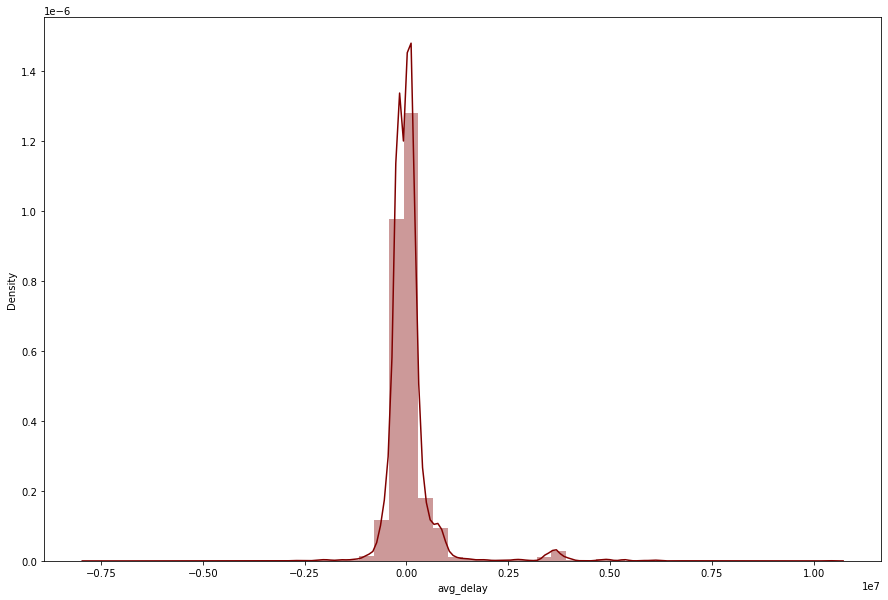

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.distplot(y_train,color='maroon')

### You are expected to group the X_train dataset on 'name_customer' column with 'doc_id' in the x_train set

### Need to store the outcome into a new dataframe 

- Note code given for groupby statement- X_train.groupby(by=['name_customer'], as_index=False)['doc_id'].count()

In [61]:
x_train=X_train.groupby(by=['name_customer'], as_index=False)['doc_id'].count()

In [62]:
x_train

,name_customer,doc_id
0,11078 us,1
1,17135 associates,1
2,17135 llc,1
3,99 CE,1
4,99 CE co,1
...,...,...
3068,Y H trust,2
3069,YAEGER corp,1
3070,YEN BROS corp,1
3071,YEN BROS corporation,1


### You can make another distribution plot of the "doc_id" column from x_train

C:\Users\yeeme\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='doc_id', ylabel='Density'>

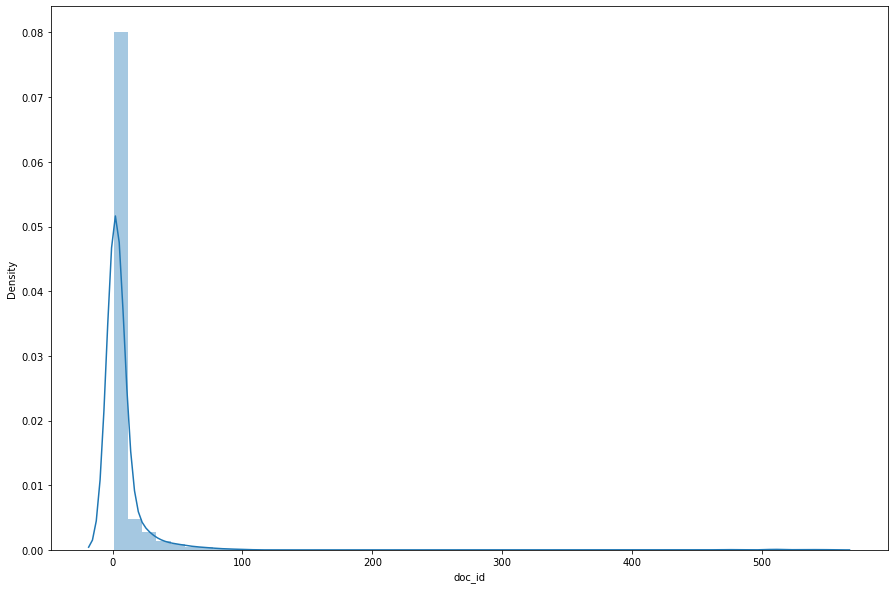

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

sns.distplot(x_train['doc_id'])

#### Create a Distribution plot only for business_year and a seperate distribution plot of "business_year" column along with the doc_id" column


C:\Users\yeeme\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='buisness_year', ylabel='Density'>

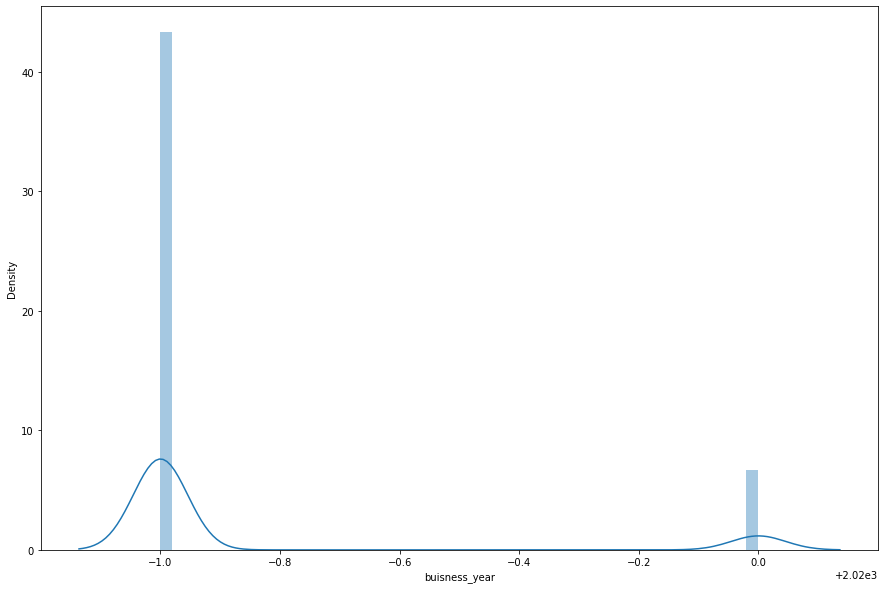

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.distplot(X_train['buisness_year'])

C:\Users\yeeme\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\yeeme\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\yeeme\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\yeeme\anaconda3\lib\site-pack

<AxesSubplot:xlabel='doc_id', ylabel='Density'>

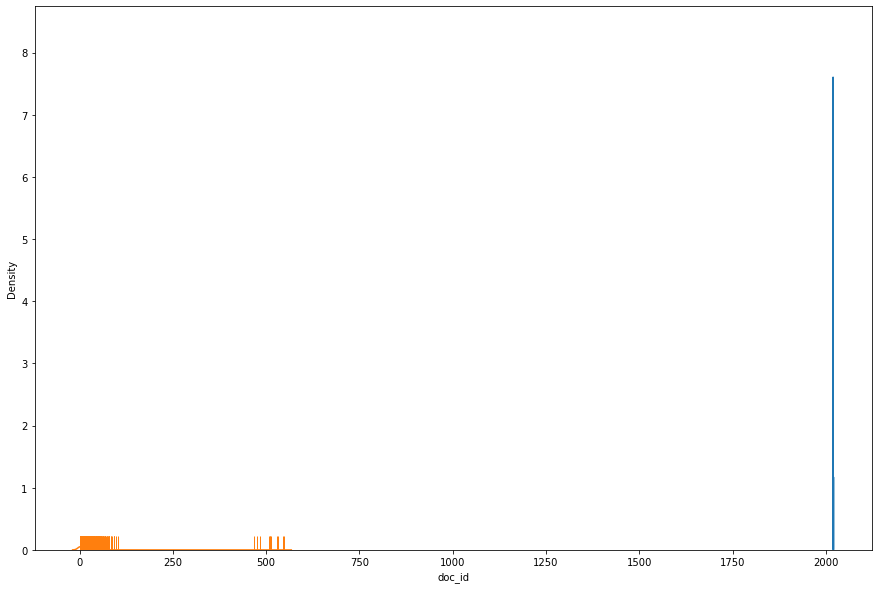

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.distplot(X_train['buisness_year'], hist=False, rug=True)
sns.distplot(x_train['doc_id'], hist=False, rug=True)

# Feature Engineering 

### Display and describe the X_train dataframe 

In [66]:
X_train.head(50)

,name_customer,business_code,cust_number,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
35886,WAL-MAR llc,U001,0200769623,2020.0,1.930437e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,16191.9100
14338,KRAFT corp,U001,CCCA02,2020.0,1.930533e+09,2020-02-18,2020-03-24,2020-02-18,NAG2,15642.7200
17006,M K llc,U013,0140102142,2019.0,1.991819e+09,2019-01-26,2019-02-25,2019-01-26,NAVE,185925.6000
30683,WAL-MAR associates,U001,0200769623,2019.0,1.928887e+09,2019-03-03,2019-03-18,2019-03-03,NAH4,12576.0300
20038,PUBLI corp,U001,0200707822,2019.0,1.929906e+09,2019-09-20,2019-10-30,2019-09-20,NAWU,1990.9300
9372,DECA systems,U001,0200592182,2019.0,1.929349e+09,2019-05-20,2019-05-26,2019-05-16,NAM2,9311.3000
25107,SYSC foundation,U001,0200331749,2019.0,1.929154e+09,2019-04-15,2019-04-30,2019-04-15,NAA8,38889.5600
21387,SA,U001,0200759878,2019.0,1.929486e+09,2019-06-13,2019-06-28,2019-06-13,NAH4,19937.1200
25318,SYSC trust,CA02,0140105686,2019.0,2.960543e+09,2019-04-22,2019-05-10,2019-04-30,CA10,188.3676
18184,MEIJ llc,U001,0200780383,2019.0,1.930009e+09,2019-10-15,2019-10-30,2019-10-15,NAA8,3357.8000


In [67]:
X_train.describe()

,buisness_year,doc_id,converted_usd
count,23494.000000,2.349400e+04,23494.000000
mean,2019.133396,2.014274e+09,31021.272839
std,0.340009,2.960690e+08,36963.450009
min,2019.000000,1.928509e+09,4.380000
25%,2019.000000,1.929181e+09,4531.002500
50%,2019.000000,1.929738e+09,17027.670000
75%,2019.000000,1.930211e+09,46134.672500
max,2020.000000,9.500000e+09,668593.360000


#### The "business_code" column inside X_train, is a categorical column, so you need to perform Labelencoder on that particular column

- Note - call the Label Encoder from sklearn library and use the fit() function on "business_code" column
- Note - Please fill in the blanks (two) to complete this code

In [68]:
from sklearn.preprocessing import LabelEncoder
business_coder = LabelEncoder()
business_coder.fit(X_train['business_code'])

LabelEncoder()

#### You are expected to store the value into a new column i.e. "business_code_enc"

- Note - For Training set you are expected to use fit_trainsform()
- Note - For Test set you are expected to use the trainsform()
- Note - For Validation set you are expected to use the trainsform()


- Partial code is provided, please fill in the blanks 

In [69]:
X_train['business_code_enc'] = business_coder.fit_transform(X_train['business_code'])

In [70]:
X_val['business_code_enc'] = business_coder.transform(X_val['business_code'])
X_test['business_code_enc'] = business_coder.transform(X_test['business_code'])

### Display "business_code" and "business_code_enc" together from X_train dataframe 

In [71]:
X_train[['business_code','business_code_enc']]

,business_code,business_code_enc
35886,U001,1
14338,U001,1
17006,U013,5
30683,U001,1
20038,U001,1
...,...,...
20757,U001,1
32103,U001,1
30403,U001,1
21243,U001,1


#### Create a function called "custom" for dropping the columns 'business_code' from train, test and validation dataframe

- Note - Fill in the blank to complete the code

In [72]:
def custom(col ,traindf = X_train,valdf = X_val,testdf = X_test):
    traindf.drop(col, axis =1,inplace=True)
    valdf.drop(col,axis=1 , inplace=True)
    testdf.drop(col,axis=1 , inplace=True)

    return traindf,valdf ,testdf

### Call the function by passing the column name which needed to be dropped from train, test and validation dataframes. Return updated dataframes to be stored in X_train ,X_val, X_test  

- Note = Fill in the blank to complete the code 

In [73]:
X_train,X_val,X_test = custom(['business_code'])

### Manually replacing str values with numbers, Here we are trying manually replace the customer numbers with some specific values like, 'CCCA' as 1, 'CCU' as 2 and so on. Also we are converting the datatype "cust_number" field to int type.

- We are doing it for all the three dataframes as shown below. This is fully completed code. No need to modify anything here 



In [74]:
X_train['cust_number'] = X_train['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(int)
X_test['cust_number'] = X_test['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(int)
X_val['cust_number'] = X_val['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(int)


#### It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]. Unknown will be added in fit and transform will take care of new item. It gives unknown class id.

#### This will fit the encoder for all the unique values and introduce unknown value

- Note - Keep this code as it is, we will be using this later on.  

In [75]:
#For encoding unseen labels
class EncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()
    def fit(self, data_list):
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self
    def transform(self, data_list):
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)

### Use the user define Label Encoder function called "EncoderExt" for the "name_customer" column

- Note - Keep the code as it is, no need to change

In [76]:
label_encoder = EncoderExt()
label_encoder.fit(X_train['name_customer'])
X_train['name_customer_enc']=label_encoder.transform(X_train['name_customer'])
X_val['name_customer_enc']=label_encoder.transform(X_val['name_customer'])
X_test['name_customer_enc']=label_encoder.transform(X_test['name_customer'])

### As we have created the a new column "name_customer_enc", so now drop "name_customer" column from all three dataframes

- Note - Keep the code as it is, no need to change

In [77]:
X_train ,X_val, X_test = custom(['name_customer'])

### Using Label Encoder for the "cust_payment_terms" column

- Note - Keep the code as it is, no need to change

In [78]:
label_encoder1 = EncoderExt()
label_encoder1.fit(X_train['cust_payment_terms'])
X_train['cust_payment_terms_enc']=label_encoder1.transform(X_train['cust_payment_terms'])
X_val['cust_payment_terms_enc']=label_encoder1.transform(X_val['cust_payment_terms'])
X_test['cust_payment_terms_enc']=label_encoder1.transform(X_test['cust_payment_terms'])

In [79]:
X_train ,X_val, X_test = custom(['cust_payment_terms'])

## Check the datatype of all the columns of Train, Test and Validation dataframes realted to X

- Note - You are expected yo use dtype

In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23494 entries, 35886 to 2732
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cust_number             23494 non-null  int32         
 1   buisness_year           23494 non-null  float64       
 2   doc_id                  23494 non-null  float64       
 3   posting_date            23494 non-null  datetime64[ns]
 4   due_in_date             23494 non-null  datetime64[ns]
 5   baseline_create_date    23494 non-null  datetime64[ns]
 6   converted_usd           23494 non-null  float64       
 7   business_code_enc       23494 non-null  int32         
 8   name_customer_enc       23494 non-null  int32         
 9   cust_payment_terms_enc  23494 non-null  int32         
dtypes: datetime64[ns](3), float64(3), int32(4)
memory usage: 1.6 MB


In [81]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 18813 to 4112
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cust_number             7832 non-null   int32         
 1   buisness_year           7832 non-null   float64       
 2   doc_id                  7832 non-null   float64       
 3   posting_date            7832 non-null   datetime64[ns]
 4   due_in_date             7832 non-null   datetime64[ns]
 5   baseline_create_date    7832 non-null   datetime64[ns]
 6   converted_usd           7832 non-null   float64       
 7   business_code_enc       7832 non-null   int32         
 8   name_customer_enc       7832 non-null   int32         
 9   cust_payment_terms_enc  7832 non-null   int32         
dtypes: datetime64[ns](3), float64(3), int32(4)
memory usage: 550.7 KB


In [82]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 32350 to 13934
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   cust_number             7832 non-null   int32         
 1   buisness_year           7832 non-null   float64       
 2   doc_id                  7832 non-null   float64       
 3   posting_date            7832 non-null   datetime64[ns]
 4   due_in_date             7832 non-null   datetime64[ns]
 5   baseline_create_date    7832 non-null   datetime64[ns]
 6   converted_usd           7832 non-null   float64       
 7   business_code_enc       7832 non-null   int32         
 8   name_customer_enc       7832 non-null   int32         
 9   cust_payment_terms_enc  7832 non-null   int32         
dtypes: datetime64[ns](3), float64(3), int32(4)
memory usage: 550.7 KB


### From the above output you can notice their are multiple date columns with datetime format

### In order to pass it into our model, we need to convert it into float format

### You need to extract day, month and year from the "posting_date" column 

1.   Extract days from "posting_date" column and store it into a new column "day_of_postingdate" for train, test and validation dataset 
2.   Extract months from "posting_date" column and store it into a new column "month_of_postingdate" for train, test and validation dataset
3.   Extract year from "posting_date" column and store it into a new column "year_of_postingdate" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year






In [83]:
X_train['day_of_postingdate'] = X_train['posting_date'].dt.day
X_train['month_of_postingdate'] = X_train['posting_date'].dt.month
X_train['year_of_postingdate'] = X_train['posting_date'].dt.year

X_val['day_of_postingdate'] = X_val['posting_date'].dt.day
X_val['month_of_postingdate'] = X_val['posting_date'].dt.month
X_val['year_of_postingdate'] = X_val['posting_date'].dt.year


X_test['day_of_postingdate'] = X_test['posting_date'].dt.day
X_test['month_of_postingdate'] = X_test['posting_date'].dt.month
X_test['year_of_postingdate'] = X_test['posting_date'].dt.year



### pass the "posting_date" column into the Custom function for train, test and validation dataset

In [84]:
X_train ,X_val, X_test = custom(['posting_date'])

### You need to extract day, month and year from the "baseline_create_date" column 

1.   Extract days from "baseline_create_date" column and store it into a new column "day_of_createdate" for train, test and validation dataset 
2.   Extract months from "baseline_create_date" column and store it into a new column "month_of_createdate" for train, test and validation dataset
3.   Extract year from "baseline_create_date" column and store it into a new column "year_of_createdate" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year


- Note - Do as it is been shown in the previous two code boxes

### Extracting Day, Month, Year for 'baseline_create_date' column

In [85]:
X_train['day_of_createdate'] = X_train['baseline_create_date'].dt.day
X_train['month_of_createdate'] = X_train['baseline_create_date'].dt.month
X_train['year_of_createdate'] = X_train['baseline_create_date'].dt.year

X_val['day_of_createdate'] = X_val['baseline_create_date'].dt.day
X_val['month_of_createdate'] = X_val['baseline_create_date'].dt.month
X_val['year_of_createdate'] = X_val['baseline_create_date'].dt.year


X_test['day_of_createdate'] = X_test['baseline_create_date'].dt.day
X_test['month_of_createdate'] = X_test['baseline_create_date'].dt.month
X_test['year_of_createdate'] = X_test['baseline_create_date'].dt.year


### pass the "baseline_create_date" column into the Custom function for train, test and validation dataset

In [86]:
X_train ,X_val, X_test = custom(['baseline_create_date'])

### You need to extract day, month and year from the "due_in_date" column 

1.   Extract days from "due_in_date" column and store it into a new column "day_of_due" for train, test and validation dataset 
2.   Extract months from "due_in_date" column and store it into a new column "month_of_due" for train, test and validation dataset
3.   Extract year from "due_in_date" column and store it into a new column "year_of_due" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year

- Note - Do as it is been shown in the previous code

In [87]:
X_train['day_of_due'] = X_train['due_in_date'].dt.day
X_train['month_of_due'] = X_train['due_in_date'].dt.month
X_train['year_of_due'] = X_train['due_in_date'].dt.year

X_val['day_of_due'] = X_val['due_in_date'].dt.day
X_val['month_of_due'] = X_val['due_in_date'].dt.month
X_val['year_of_due'] = X_val['due_in_date'].dt.year


X_test['day_of_due'] = X_test['due_in_date'].dt.day
X_test['month_of_due'] = X_test['due_in_date'].dt.month
X_test['year_of_due'] = X_test['due_in_date'].dt.year

pass the "due_in_date" column into the Custom function for train, test and validation dataset

In [88]:
X_train ,X_val, X_test = custom(['due_in_date'])

### Check for the datatypes for train, test and validation set again

- Note - all the data type should be in either int64 or float64 format 


In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23494 entries, 35886 to 2732
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             23494 non-null  int32  
 1   buisness_year           23494 non-null  float64
 2   doc_id                  23494 non-null  float64
 3   converted_usd           23494 non-null  float64
 4   business_code_enc       23494 non-null  int32  
 5   name_customer_enc       23494 non-null  int32  
 6   cust_payment_terms_enc  23494 non-null  int32  
 7   day_of_postingdate      23494 non-null  int64  
 8   month_of_postingdate    23494 non-null  int64  
 9   year_of_postingdate     23494 non-null  int64  
 10  day_of_createdate       23494 non-null  int64  
 11  month_of_createdate     23494 non-null  int64  
 12  year_of_createdate      23494 non-null  int64  
 13  day_of_due              23494 non-null  int64  
 14  month_of_due            23494 non-n

In [90]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 32350 to 13934
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             7832 non-null   int32  
 1   buisness_year           7832 non-null   float64
 2   doc_id                  7832 non-null   float64
 3   converted_usd           7832 non-null   float64
 4   business_code_enc       7832 non-null   int32  
 5   name_customer_enc       7832 non-null   int32  
 6   cust_payment_terms_enc  7832 non-null   int32  
 7   day_of_postingdate      7832 non-null   int64  
 8   month_of_postingdate    7832 non-null   int64  
 9   year_of_postingdate     7832 non-null   int64  
 10  day_of_createdate       7832 non-null   int64  
 11  month_of_createdate     7832 non-null   int64  
 12  year_of_createdate      7832 non-null   int64  
 13  day_of_due              7832 non-null   int64  
 14  month_of_due            7832 non-nu

In [91]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 18813 to 4112
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             7832 non-null   int32  
 1   buisness_year           7832 non-null   float64
 2   doc_id                  7832 non-null   float64
 3   converted_usd           7832 non-null   float64
 4   business_code_enc       7832 non-null   int32  
 5   name_customer_enc       7832 non-null   int32  
 6   cust_payment_terms_enc  7832 non-null   int32  
 7   day_of_postingdate      7832 non-null   int64  
 8   month_of_postingdate    7832 non-null   int64  
 9   year_of_postingdate     7832 non-null   int64  
 10  day_of_createdate       7832 non-null   int64  
 11  month_of_createdate     7832 non-null   int64  
 12  year_of_createdate      7832 non-null   int64  
 13  day_of_due              7832 non-null   int64  
 14  month_of_due            7832 non-nul

# Feature Selection

### Filter Method

- Calling the VarianceThreshold Function 
- Note - Keep the code as it is, no need to change 

In [92]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train)
len(X_train.columns[constant_filter.get_support()])

16

- Note - Keep the code as it is, no need to change 


In [93]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant_filter.get_support()]]
print(len(constant_columns))

0


- transpose the feature matrice
- print the number of duplicated features
- select the duplicated features columns names

- Note - Keep the code as it is, no need to change 


In [94]:
x_train_T = X_train.T
print(x_train_T.duplicated().sum())
duplicated_columns = x_train_T[x_train_T.duplicated()].index.values

0


### Filtering depending upon correlation matrix value
- We have created a function called handling correlation which is going to return fields based on the correlation matrix value with a threshold of 0.8

- Note - Keep the code as it is, no need to change 

In [95]:
def handling_correlation(X_train,threshold=0.8):
    corr_features = set()
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)
    return list(corr_features)

- Note : Here we are trying to find out the relevant fields, from X_train
- Please fill in the blanks to call handling_correlation() function with a threshold value of 0.85

In [96]:
train=X_train.copy()
handling_correlation(train.copy(),0.85)

['year_of_createdate',
 'year_of_due',
 'day_of_createdate',
 'month_of_due',
 'year_of_postingdate',
 'month_of_createdate']

### Heatmap for X_train

- Note - Keep the code as it is, no need to change

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

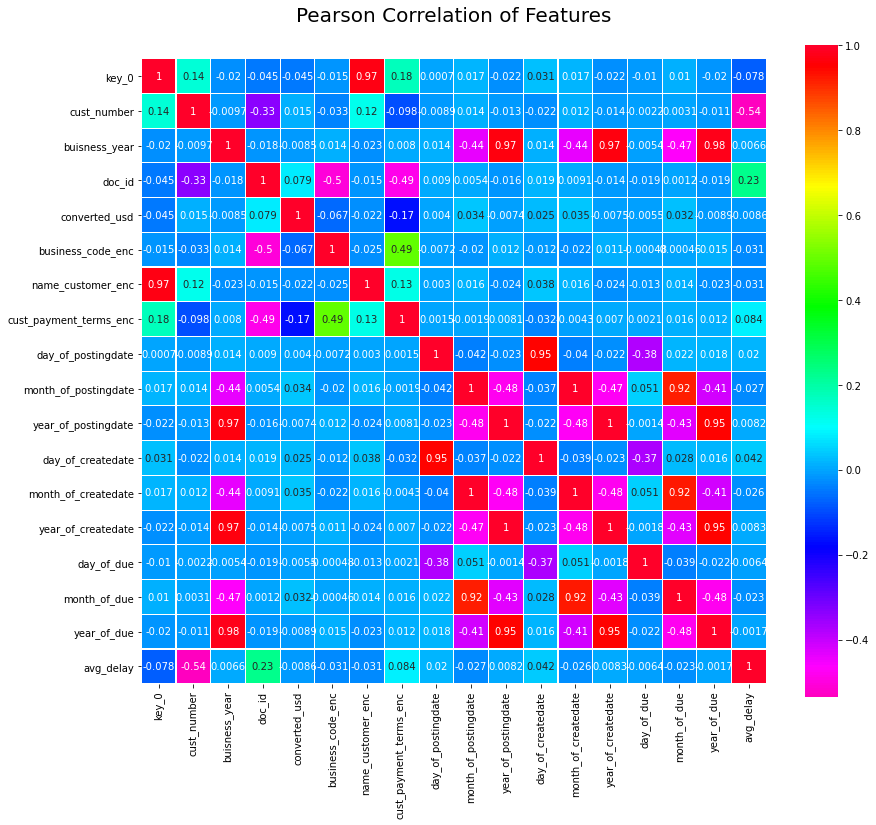

In [97]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(X_train.merge(y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='gist_rainbow_r', linecolor='white', annot=True)

#### Calling variance threshold for threshold value = 0.8

- Note -  Fill in the blanks to call the appropriate method

In [98]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.8)
sel.fit(X_train)

VarianceThreshold(threshold=0.8)

In [99]:
sel.variances_

array([1.77226100e+15, 1.15601332e-01, 8.76531009e+16, 1.36623848e+09,
       2.75502859e-01, 1.07205022e+06, 1.27747208e+02, 7.58920571e+01,
       1.22867981e+01, 1.16586526e-01, 7.75097235e+01, 1.22926951e+01,
       1.16713969e-01, 7.63061916e+01, 1.21060948e+01, 1.18952006e-01])

### Features columns are 
- 'year_of_createdate' 
- 'year_of_due'
- 'day_of_createdate'
- 'year_of_postingdate'
- 'month_of_due'
- 'month_of_createdate'

# Modelling 

#### Now you need to compare with different machine learning models, and needs to find out the best predicted model

- Linear Regression
- Decision Tree Regression
- Random Forest Regression
- Support Vector Regression
- Extreme Gradient Boost Regression 

### You need to make different blank list for different evaluation matrix 

- MSE
- R2
- Algorithm

In [100]:
MSE_Score = []
R2_Score = []
Algorithm = []
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### You need to start with the baseline model Linear Regression

- Step 1 : Call the Linear Regression from sklearn library
- Step 2 : make an object of Linear Regression 
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [101]:
from sklearn.linear_model import LinearRegression
Algorithm.append('LinearRegression')
regressor = LinearRegression()
regressor.fit(X_train, y_train)
predicted= regressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [102]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [103]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

534375.2347036807

### Display The Comparison Lists

In [104]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression'],[278953921988.43475],[0.28094901355051605],

### You need to start with the baseline model Support Vector Regression

- Step 1 : Call the Support Vector Regressor from sklearn library
- Step 2 : make an object of SVR
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [105]:
from sklearn.svm import SVR
Algorithm.append('SVR')
SVregressor = SVR()
SVregressor.fit(X_train, y_train)
predicted= SVregressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for "y_test" and "predicted" dataset and store those data inside respective list for comparison 

In [106]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [107]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

534375.2347036807

### Display The Comparison Lists

In [108]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'SVR'],[278953921988.43475, 389133184398.8026],[0.28094901355051605, -0.0030566987826348146],

### Your next model would be Decision Tree Regression

- Step 1 : Call the Decision Tree Regressor from sklearn library
- Step 2 : make an object of Decision Tree
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [109]:
from sklearn.tree import DecisionTreeRegressor
Algorithm.append('DecisionTreeRegressor')
DTregressor = DecisionTreeRegressor()
DTregressor.fit(X_train, y_train)
predicted= DTregressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [110]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [111]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

534375.2347036807

### Display The Comparison Lists

In [112]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'SVR', 'DecisionTreeRegressor'],[278953921988.43475, 389133184398.8026, 253280685378.46753],[0.28094901355051605, -0.0030566987826348146, 0.34712612975006263],

### Your next model would be Random Forest Regression

- Step 1 : Call the Random Forest Regressor from sklearn library
- Step 2 : make an object of Random Forest
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [113]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('RandomForestRegressor')
RFregressor = RandomForestRegressor()
RFregressor.fit(X_train, y_train)
predicted= RFregressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [114]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [115]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

534375.2347036807

### Display The Comparison Lists


In [116]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'SVR', 'DecisionTreeRegressor', 'RandomForestRegressor'],[278953921988.43475, 389133184398.8026, 253280685378.46753, 118669513065.47826],[0.28094901355051605, -0.0030566987826348146, 0.34712612975006263, 0.6941092284239339],

### The last but not the least model would be XGBoost or Extreme Gradient Boost Regression

- Step 1 : Call the XGBoost Regressor from xgb library
- Step 2 : make an object of Xgboost
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose### Extreme Gradient Boost Regression
- Note -  No need to change the code 

In [117]:
import xgboost as xgb
Algorithm.append('XGB Regressor')
XGBregressor = xgb.XGBRegressor()
XGBregressor.fit(X_train, y_train)
predicted = XGBregressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [118]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [119]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

534375.2347036807

### Display The Comparison Lists


In [120]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'SVR', 'DecisionTreeRegressor', 'RandomForestRegressor', 'XGB Regressor'],[278953921988.43475, 389133184398.8026, 253280685378.46753, 118669513065.47826, 102401390865.36208],[0.28094901355051605, -0.0030566987826348146, 0.34712612975006263, 0.6941092284239339, 0.7360430690822461],

## You need to make the comparison list into a comparison dataframe 

In [121]:
 new_df=pd.DataFrame(np.column_stack([Algorithm,MSE_Score,R2_Score]), 
                               columns=['Algorithm', 'MSE_Score', 'R2_Score'])

In [122]:
new_df

,Algorithm,MSE_Score,R2_Score
0,LinearRegression,278953921988.43475,0.28094901355051605
1,SVR,389133184398.8026,-0.0030566987826348146
2,DecisionTreeRegressor,253280685378.46753,0.34712612975006263
3,RandomForestRegressor,118669513065.47826,0.6941092284239339
4,XGB Regressor,102401390865.36208,0.7360430690822461


## Now from the Comparison table, you need to choose the best fit model

- Step 1 - Fit X_train and y_train inside the model 
- Step 2 - Predict the X_test dataset
- Step 3 - Predict the X_val dataset


- Note - No need to change the code

In [123]:
regressorfinal = xgb.XGBRegressor()
regressorfinal.fit(X_train, y_train)
predictedfinal = regressorfinal.predict(X_test)
predict_testfinal = regressorfinal.predict(X_val)

In [124]:
predict_testfinal

array([-222351.9 , -231226.22,  720241.94, ...,  130077.9 ,  116671.25,
       -149658.19], dtype=float32)

### Calculate the Mean Square Error for test dataset

- Note - No need to change the code

In [125]:
mean_squared_error(y_test,predictedfinal,squared=False)

320002.1732197487

### Calculate the mean Square Error for validation dataset

In [126]:
mean_squared_error(y_val,predictedfinal,squared=False)

866792.9768254162

### Calculate the R2 score for test

In [127]:
r2_score(y_test,predictedfinal)

0.7360430690822461

### Calculate the R2 score for Validation

In [128]:
r2_score(y_val,predictedfinal)

-0.6266279616955264

### Calculate the Accuracy for train Dataset 

In [129]:
regressorfinal.score(X_train,y_train)

0.9542623468957253

### Calculate the accuracy for validation

In [130]:
regressorfinal.score(X_val,y_val)

0.7557810663981845

### Calculate the accuracy for test

In [131]:
regressorfinal.score(X_test,y_test)

0.7360430690822461

## Specify the reason behind choosing your machine learning model 

- Note :Mean Square error is the average of the square of the error.The Larger the number the larger the error. low R-Squared such as 0.75 could be considered relatively strong.In above case we saw that xgb model is the best fit satisfy all the required conditions such as lowest in mean_square_error and close near to 0.75 of r2_score.Validation and test socre are close that mean it avoid overfiting

## Now you need to pass the Nulldata dataframe into this machine learning model

#### In order to pass this Nulldata dataframe into the ML model, we need to perform the following

- Step 1 : Label Encoding 
- Step 2 : Day, Month and Year extraction 
- Step 3 : Change all the column data type into int64 or float64
- Step 4 : Need to drop the useless columns 

### Display the Nulldata 

In [132]:
nulldata.head(10)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
5,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
8,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
12,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
13,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06
20,U001,0200744019,TARG associates,NaT,2020.0,1.930676e+09,2020-03-21,2020-04-05,2020-03-21,NAA8,5893.01
24,U001,0200337148,COAS llc,NaT,2020.0,1.930592e+09,2020-03-02,2020-03-17,2020-03-02,NAA8,11380.83
31,U001,0200794332,COST associates,NaT,2020.0,1.930731e+09,2020-04-07,2020-04-22,2020-04-07,NAAX,3863.93
33,U001,0200794332,COST llc,NaT,2020.0,1.930804e+09,2020-04-23,2020-05-08,2020-04-23,NAAX,74453.01
40,U001,0200803720,DEC corp,NaT,2020.0,1.930698e+09,2020-03-25,2020-04-08,2020-03-16,NAM4,138.60
46,U001,0200794332,COST co,NaT,2020.0,1.930647e+09,2020-03-13,2020-03-28,2020-03-13,NAAX,32715.47


### Check for the number of rows and columns in the nulldata

In [133]:
nulldata.shape

(9681, 11)

### Check the Description and Information of the nulldata 

In [134]:
nulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 5 to 48837
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         9681 non-null   object        
 1   cust_number           9681 non-null   object        
 2   name_customer         9681 non-null   object        
 3   clear_date            0 non-null      datetime64[ns]
 4   buisness_year         9681 non-null   float64       
 5   doc_id                9681 non-null   float64       
 6   posting_date          9681 non-null   datetime64[ns]
 7   due_in_date           9681 non-null   datetime64[ns]
 8   baseline_create_date  9681 non-null   datetime64[ns]
 9   cust_payment_terms    9681 non-null   object        
 10  converted_usd         9681 non-null   float64       
dtypes: datetime64[ns](4), float64(3), object(4)
memory usage: 907.6+ KB


In [135]:
nulldata.describe()

,buisness_year,doc_id,converted_usd
count,9681.0,9.681000e+03,9681.000000
mean,2020.0,2.006165e+09,32458.165080
std,0.0,2.673629e+08,36023.578028
min,2020.0,1.930535e+09,0.720000
25%,2020.0,1.930658e+09,5624.120000
50%,2020.0,1.930731e+09,19175.380000
75%,2020.0,1.930818e+09,48346.550000
max,2020.0,2.960636e+09,653644.800000


### Storing the Nulldata into a different dataset 
# for BACKUP

In [136]:
nulldata2=nulldata.copy()

In [137]:
nulldata2.head(10)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
5,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
8,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
12,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
13,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06
20,U001,0200744019,TARG associates,NaT,2020.0,1.930676e+09,2020-03-21,2020-04-05,2020-03-21,NAA8,5893.01
24,U001,0200337148,COAS llc,NaT,2020.0,1.930592e+09,2020-03-02,2020-03-17,2020-03-02,NAA8,11380.83
31,U001,0200794332,COST associates,NaT,2020.0,1.930731e+09,2020-04-07,2020-04-22,2020-04-07,NAAX,3863.93
33,U001,0200794332,COST llc,NaT,2020.0,1.930804e+09,2020-04-23,2020-05-08,2020-04-23,NAAX,74453.01
40,U001,0200803720,DEC corp,NaT,2020.0,1.930698e+09,2020-03-25,2020-04-08,2020-03-16,NAM4,138.60
46,U001,0200794332,COST co,NaT,2020.0,1.930647e+09,2020-03-13,2020-03-28,2020-03-13,NAAX,32715.47


### Call the Label Encoder for Nulldata

- Note - you are expected to fit "business_code" as it is a categorical variable
- Note - No need to change the code

In [138]:
from sklearn.preprocessing import LabelEncoder
business_codern = LabelEncoder()
business_codern.fit(nulldata['business_code'])
nulldata['business_code_enc'] = business_codern.transform(nulldata['business_code'])

### Now you need to manually replacing str values with numbers
- Note - No need to change the code

In [139]:
nulldata['cust_number'] = nulldata['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(int)

## You need to extract day, month and year from the "clear_date", "posting_date", "due_in_date", "baseline_create_date" columns


##### 1.   Extract day from "clear_date" column and store it into 'day_of_cleardate'
##### 2.   Extract month from "clear_date" column and store it into 'month_of_cleardate'
##### 3.   Extract year from "clear_date" column and store it into 'year_of_cleardate'



##### 4.   Extract day from "posting_date" column and store it into 'day_of_postingdate'
##### 5.   Extract month from "posting_date" column and store it into 'month_of_postingdate'
##### 6.   Extract year from "posting_date" column and store it into 'year_of_postingdate'




##### 7.   Extract day from "due_in_date" column and store it into 'day_of_due'
##### 8.   Extract month from "due_in_date" column and store it into 'month_of_due'
##### 9.   Extract year from "due_in_date" column and store it into 'year_of_due'




##### 10.   Extract day from "baseline_create_date" column and store it into 'day_of_createdate'
##### 11.   Extract month from "baseline_create_date" column and store it into 'month_of_createdate'
##### 12.   Extract year from "baseline_create_date" column and store it into 'year_of_createdate'




- Note - You are supposed To use - 

*   dt.day
*   dt.month
*   dt.year

In [140]:
nulldata['day_of_cleardate'] = nulldata['clear_date'].dt.day
nulldata['month_of_cleardate'] = nulldata['clear_date'].dt.month
nulldata['year_of_cleardate'] = nulldata['clear_date'].dt.year

nulldata['day_of_postingdate'] = nulldata['posting_date'].dt.day
nulldata['month_of_postingdate'] = nulldata['posting_date'].dt.month
nulldata['year_of_postingdate'] = nulldata['posting_date'].dt.year

nulldata['day_of_due'] = nulldata['due_in_date'].dt.day
nulldata['month_of_due'] = nulldata['due_in_date'].dt.month
nulldata['year_of_due'] = nulldata['due_in_date'].dt.year

nulldata['day_of_createdate'] = nulldata['baseline_create_date'].dt.day
nulldata['month_of_createdate'] = nulldata['baseline_create_date'].dt.month
nulldata['year_of_createdate'] = nulldata['baseline_create_date'].dt.year


### Use Label Encoder1 of all the following columns - 
- 'cust_payment_terms' and store into 'cust_payment_terms_enc'
- 'business_code' and store into 'business_code_enc'
- 'name_customer' and store into 'name_customer_enc'

Note - No need to change the code

In [141]:
nulldata['cust_payment_terms_enc']=label_encoder1.transform(nulldata['cust_payment_terms'])
nulldata['business_code_enc']=label_encoder1.transform(nulldata['business_code'])
nulldata['name_customer_enc']=label_encoder.transform(nulldata['name_customer'])


### Check for the datatypes of all the columns of Nulldata

In [142]:
nulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 5 to 48837
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   business_code           9681 non-null   object        
 1   cust_number             9681 non-null   int32         
 2   name_customer           9681 non-null   object        
 3   clear_date              0 non-null      datetime64[ns]
 4   buisness_year           9681 non-null   float64       
 5   doc_id                  9681 non-null   float64       
 6   posting_date            9681 non-null   datetime64[ns]
 7   due_in_date             9681 non-null   datetime64[ns]
 8   baseline_create_date    9681 non-null   datetime64[ns]
 9   cust_payment_terms      9681 non-null   object        
 10  converted_usd           9681 non-null   float64       
 11  business_code_enc       9681 non-null   int32         
 12  day_of_cleardate        0 non-null      float64

### Now you need to drop all the unnecessary columns - 

- 'business_code'
- "baseline_create_date"
- "due_in_date"
- "posting_date"
- "name_customer"
- "clear_date"
- "cust_payment_terms"
- 'day_of_cleardate'
- "month_of_cleardate"
- "year_of_cleardate"

In [143]:
nulldata.drop(columns=['business_code',"baseline_create_date","due_in_date",
                       "posting_date","name_customer","clear_date","cust_payment_terms",
                       'day_of_cleardate',"month_of_cleardate",
                       "year_of_cleardate"],inplace=True)

### Check the information of the "nulldata" dataframe

In [144]:
nulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 5 to 48837
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             9681 non-null   int32  
 1   buisness_year           9681 non-null   float64
 2   doc_id                  9681 non-null   float64
 3   converted_usd           9681 non-null   float64
 4   business_code_enc       9681 non-null   int32  
 5   day_of_postingdate      9681 non-null   int64  
 6   month_of_postingdate    9681 non-null   int64  
 7   year_of_postingdate     9681 non-null   int64  
 8   day_of_due              9681 non-null   int64  
 9   month_of_due            9681 non-null   int64  
 10  year_of_due             9681 non-null   int64  
 11  day_of_createdate       9681 non-null   int64  
 12  month_of_createdate     9681 non-null   int64  
 13  year_of_createdate      9681 non-null   int64  
 14  cust_payment_terms_enc  9681 non-null  

### Compare "nulldata" with the "X_test" dataframe 

- use info() method

In [145]:
nulldata.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 5 to 48837
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             9681 non-null   int32  
 1   buisness_year           9681 non-null   float64
 2   doc_id                  9681 non-null   float64
 3   converted_usd           9681 non-null   float64
 4   business_code_enc       9681 non-null   int32  
 5   day_of_postingdate      9681 non-null   int64  
 6   month_of_postingdate    9681 non-null   int64  
 7   year_of_postingdate     9681 non-null   int64  
 8   day_of_due              9681 non-null   int64  
 9   month_of_due            9681 non-null   int64  
 10  year_of_due             9681 non-null   int64  
 11  day_of_createdate       9681 non-null   int64  
 12  month_of_createdate     9681 non-null   int64  
 13  year_of_createdate      9681 non-null   int64  
 14  cust_payment_terms_enc  9681 non-null  

### You must have noticed that there is a mismatch in the column sequence while compairing the dataframes

- Note - In order to fed into the machine learning model, you need to edit the sequence of "nulldata", similar to the "X_test" dataframe

- Display all the columns of the X_test dataframe 
- Display all the columns of the Nulldata dataframe 
- Store the Nulldata with new sequence into a new dataframe 


- Note - The code is given below, no need to change 

In [146]:
X_test.columns

Index(['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'name_customer_enc', 'cust_payment_terms_enc',
       'day_of_postingdate', 'month_of_postingdate', 'year_of_postingdate',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'day_of_due', 'month_of_due', 'year_of_due'],
      dtype='object')

In [147]:
nulldata.columns

Index(['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'day_of_postingdate', 'month_of_postingdate',
       'year_of_postingdate', 'day_of_due', 'month_of_due', 'year_of_due',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'cust_payment_terms_enc', 'name_customer_enc'],
      dtype='object')

In [148]:
nulldata3=nulldata[['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'name_customer_enc', 'cust_payment_terms_enc',
       'day_of_postingdate', 'month_of_postingdate', 'year_of_postingdate',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'day_of_due', 'month_of_due', 'year_of_due']]

### Display the Final Dataset

In [149]:
nulldata3.head(50)

,cust_number,buisness_year,doc_id,converted_usd,business_code_enc,name_customer_enc,cust_payment_terms_enc,day_of_postingdate,month_of_postingdate,year_of_postingdate,day_of_createdate,month_of_createdate,year_of_createdate,day_of_due,month_of_due,year_of_due
5,200744019,2020.0,1.930659e+09,11173.02,63,2783,18,19,3,2020,19,3,2020,3,4,2020
8,200418007,2020.0,1.930611e+09,3525.59,63,86,18,11,3,2020,11,3,2020,26,3,2020
12,200739534,2020.0,1.930788e+09,121105.65,63,2013,18,15,4,2020,15,4,2020,30,4,2020
13,200353024,2020.0,1.930817e+09,3726.06,63,710,34,23,4,2020,16,4,2020,26,4,2020
20,200744019,2020.0,1.930676e+09,5893.01,63,2774,18,21,3,2020,21,3,2020,5,4,2020
24,200337148,2020.0,1.930592e+09,11380.83,63,542,18,2,3,2020,2,3,2020,17,3,2020
31,200794332,2020.0,1.930731e+09,3863.93,63,606,20,7,4,2020,7,4,2020,22,4,2020
33,200794332,2020.0,1.930804e+09,74453.01,63,612,20,23,4,2020,23,4,2020,8,5,2020
40,200803720,2020.0,1.930698e+09,138.60,63,698,36,25,3,2020,16,3,2020,8,4,2020
46,200794332,2020.0,1.930647e+09,32715.47,63,607,20,13,3,2020,13,3,2020,28,3,2020


### Now you can pass this dataset into you final model and store it into "final_result"

In [150]:
final_result=regressorfinal.predict(nulldata3)

In [151]:
final_result

array([  25023.787, -137602.81 , -583542.   , ...,  818752.3  ,
         83914.14 , -100495.56 ], dtype=float32)

### you need to make the final_result as dataframe, with a column name "avg_delay"

- Note - No need to change the code

In [152]:
final_result = pd.Series(final_result,name='avg_delay')

### Display the "avg_delay" column

In [153]:
final_result

0        25023.787109
1      -137602.812500
2      -583542.000000
3      -410204.625000
4        19451.865234
            ...      
9676    351083.500000
9677     47019.328125
9678    818752.312500
9679     83914.140625
9680   -100495.562500
Name: avg_delay, Length: 9681, dtype: float32

### Now you need to merge this final_result dataframe with the BACKUP of "nulldata" Dataframe which we have created in earlier steps

In [154]:
nulldata2.reset_index(drop=True,inplace=True)
Final = nulldata2.merge(final_result , on = nulldata.index )

### Display the "Final" dataframe 

In [155]:
Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay
0,5,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.0200,25023.787109
1,8,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.5900,-137602.812500
2,12,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.6500,-583542.000000
3,13,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.0600,-410204.625000
4,20,U001,0200744019,TARG associates,NaT,2020.0,1.930676e+09,2020-03-21,2020-04-05,2020-03-21,NAA8,5893.0100,19451.865234
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,48809,CA02,0140104440,SO corporation,NaT,2020.0,2.960622e+09,2020-03-16,2020-03-28,2020-03-18,CA10,47983.1543,351083.500000
9677,48830,CA02,0140104472,MARTIN llc,NaT,2020.0,2.960618e+09,2020-03-04,2020-03-16,2020-03-06,CA10,23868.2700,47019.328125
9678,48833,CA02,140106408,WAL-M associates,NaT,2020.0,2.960628e+09,2020-04-12,2020-04-22,2020-04-12,CA10,6746.9002,818752.312500
9679,48834,CA02,0140104472,MARTIN associates,NaT,2020.0,2.960628e+09,2020-04-17,2020-05-02,2020-04-22,CA10,1301.4144,83914.140625


In [156]:
Final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 0 to 9680
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key_0                 9681 non-null   int64         
 1   business_code         9681 non-null   object        
 2   cust_number           9681 non-null   object        
 3   name_customer         9681 non-null   object        
 4   clear_date            0 non-null      datetime64[ns]
 5   buisness_year         9681 non-null   float64       
 6   doc_id                9681 non-null   float64       
 7   posting_date          9681 non-null   datetime64[ns]
 8   due_in_date           9681 non-null   datetime64[ns]
 9   baseline_create_date  9681 non-null   datetime64[ns]
 10  cust_payment_terms    9681 non-null   object        
 11  converted_usd         9681 non-null   float64       
 12  avg_delay             9681 non-null   float32       
dtypes: datetime64[ns](

### Check for the Number of Rows and Columns in your "Final" dataframe 

In [157]:
Final.shape

(9681, 13)

### Now, you need to do convert the below fields back into date and time format 

- Convert "due_in_date" into datetime format
- Convert "avg_delay" into datetime format
- Create a new column "clear_date" and store the sum of "due_in_date" and "avg_delay"
- display the new "clear_date" column
- Note - Code is given below, no need to change 

In [158]:
Final['clear_date'] = pd.to_datetime(Final['due_in_date']) + pd.to_timedelta(Final['avg_delay'], unit='s')

### Display the "clear_date" column

In [159]:
Final[['clear_date']]

,clear_date
0,2020-04-03 06:57:03.787109375
1,2020-03-24 09:46:37.187500000
2,2020-04-23 05:54:18.000000000
3,2020-04-21 06:03:15.375000000
4,2020-04-05 05:24:11.865234375
...,...
9676,2020-04-01 01:31:23.500000000
9677,2020-03-16 13:03:39.328125000
9678,2020-05-01 11:25:52.312500000
9679,2020-05-02 23:18:34.140625000


### Convert the average delay into number of days format 

- Note - Formula = avg_delay//(24 * 3600)
- Note - full code is given for this, no need to change 

In [160]:
Final['avg_delay'] = Final.apply(lambda row: row.avg_delay//(24 * 3600), axis = 1)

### Display the "avg_delay" column 

In [161]:
Final[['avg_delay']]

,avg_delay
0,0.0
1,-2.0
2,-7.0
3,-5.0
4,0.0
...,...
9676,4.0
9677,0.0
9678,9.0
9679,0.0


In [162]:
Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay
0,5,U001,0200744019,TARG us,2020-04-03 06:57:03.787109375,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.0200,0.0
1,8,U001,0200418007,AM,2020-03-24 09:46:37.187500000,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.5900,-2.0
2,12,U001,0200739534,OK systems,2020-04-23 05:54:18.000000000,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.6500,-7.0
3,13,U001,0200353024,DECA corporation,2020-04-21 06:03:15.375000000,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.0600,-5.0
4,20,U001,0200744019,TARG associates,2020-04-05 05:24:11.865234375,2020.0,1.930676e+09,2020-03-21,2020-04-05,2020-03-21,NAA8,5893.0100,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,48809,CA02,0140104440,SO corporation,2020-04-01 01:31:23.500000000,2020.0,2.960622e+09,2020-03-16,2020-03-28,2020-03-18,CA10,47983.1543,4.0
9677,48830,CA02,0140104472,MARTIN llc,2020-03-16 13:03:39.328125000,2020.0,2.960618e+09,2020-03-04,2020-03-16,2020-03-06,CA10,23868.2700,0.0
9678,48833,CA02,140106408,WAL-M associates,2020-05-01 11:25:52.312500000,2020.0,2.960628e+09,2020-04-12,2020-04-22,2020-04-12,CA10,6746.9002,9.0
9679,48834,CA02,0140104472,MARTIN associates,2020-05-02 23:18:34.140625000,2020.0,2.960628e+09,2020-04-17,2020-05-02,2020-04-22,CA10,1301.4144,0.0


### Now you need to convert average delay column into bucket

- Need to perform binning 
- create a list of bins i.e. bins= [0,15,30,45,60,100]
- create a list of labels i.e. labels = ['0-15','16-30','31-45','46-60','Greatar than 60']
- perform binning by using cut() function from "Final" dataframe


- Please fill up the first two rows of the code

In [163]:

# bins= [0,15,30,45,60,100]
# labels = ['0','0-15','16-30','31-45','46-60','Greatar than 60']
# Final['Aging Bucket'] = pd.cut(Final['avg_delay'], bins=bins, labels=labels, right=False)
def bucketizzation(x):
    if x<0:
        return('0')
    elif x in range(0,16):
        return('0-15')
    elif x in range(16,31):
        return('16-30')
    elif x in range(31,45):
        return('31-45')
    elif x in range(45,60):
        return('45-60')
    else:
        return('Greater than 60')
Final['Aging Bucket']=pd.Series([bucketizzation(x=Final['avg_delay'][i]) for i in range(len(Final))])

In [164]:
Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay,Aging Bucket
0,5,U001,0200744019,TARG us,2020-04-03 06:57:03.787109375,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.0200,0.0,0-15
1,8,U001,0200418007,AM,2020-03-24 09:46:37.187500000,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.5900,-2.0,0
2,12,U001,0200739534,OK systems,2020-04-23 05:54:18.000000000,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.6500,-7.0,0
3,13,U001,0200353024,DECA corporation,2020-04-21 06:03:15.375000000,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.0600,-5.0,0
4,20,U001,0200744019,TARG associates,2020-04-05 05:24:11.865234375,2020.0,1.930676e+09,2020-03-21,2020-04-05,2020-03-21,NAA8,5893.0100,0.0,0-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,48809,CA02,0140104440,SO corporation,2020-04-01 01:31:23.500000000,2020.0,2.960622e+09,2020-03-16,2020-03-28,2020-03-18,CA10,47983.1543,4.0,0-15
9677,48830,CA02,0140104472,MARTIN llc,2020-03-16 13:03:39.328125000,2020.0,2.960618e+09,2020-03-04,2020-03-16,2020-03-06,CA10,23868.2700,0.0,0-15
9678,48833,CA02,140106408,WAL-M associates,2020-05-01 11:25:52.312500000,2020.0,2.960628e+09,2020-04-12,2020-04-22,2020-04-12,CA10,6746.9002,9.0,0-15
9679,48834,CA02,0140104472,MARTIN associates,2020-05-02 23:18:34.140625000,2020.0,2.960628e+09,2020-04-17,2020-05-02,2020-04-22,CA10,1301.4144,0.0,0-15


### Now you need to drop "key_0" and "avg_delay" columns from the "Final" Dataframe

In [165]:
Final.drop(columns=['key_0','avg_delay'],inplace=True)

In [166]:
Final

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Aging Bucket
0,U001,0200744019,TARG us,2020-04-03 06:57:03.787109375,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.0200,0-15
1,U001,0200418007,AM,2020-03-24 09:46:37.187500000,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.5900,0
2,U001,0200739534,OK systems,2020-04-23 05:54:18.000000000,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.6500,0
3,U001,0200353024,DECA corporation,2020-04-21 06:03:15.375000000,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.0600,0
4,U001,0200744019,TARG associates,2020-04-05 05:24:11.865234375,2020.0,1.930676e+09,2020-03-21,2020-04-05,2020-03-21,NAA8,5893.0100,0-15
...,...,...,...,...,...,...,...,...,...,...,...,...
9676,CA02,0140104440,SO corporation,2020-04-01 01:31:23.500000000,2020.0,2.960622e+09,2020-03-16,2020-03-28,2020-03-18,CA10,47983.1543,0-15
9677,CA02,0140104472,MARTIN llc,2020-03-16 13:03:39.328125000,2020.0,2.960618e+09,2020-03-04,2020-03-16,2020-03-06,CA10,23868.2700,0-15
9678,CA02,140106408,WAL-M associates,2020-05-01 11:25:52.312500000,2020.0,2.960628e+09,2020-04-12,2020-04-22,2020-04-12,CA10,6746.9002,0-15
9679,CA02,0140104472,MARTIN associates,2020-05-02 23:18:34.140625000,2020.0,2.960628e+09,2020-04-17,2020-05-02,2020-04-22,CA10,1301.4144,0-15


### Display the count of each categoty of new "Aging Bucket" column 

In [167]:
Final['Aging Bucket'].value_counts()

0                  5216
0-15               4383
31-45                52
45-60                19
16-30                 9
Greater than 60       2
Name: Aging Bucket, dtype: int64

### Display your final dataset with aging buckets 

In [168]:
Final[['Aging Bucket']]

,Aging Bucket
0,0-15
1,0
2,0
3,0
4,0-15
...,...
9676,0-15
9677,0-15
9678,0-15
9679,0-15


### Store this dataframe into the .csv format

In [170]:
Final.to_csv('HRC70513W_YEEMENTH_DHANRAJ_VIRUTKAR_GHI.csv',index=False)

# END OF THE PROJECT